In [1]:
! pip install transformers pytorch-lightning --quiet

In [2]:
import torch
import math
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchmetrics import Accuracy

2024-02-25 15:00:58.942988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 15:00:58.943092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 15:00:59.096289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Importing Kaggle Dataset**

In [3]:
train_path='/kaggle/input/garbage-classification/garbage_classification'

In [4]:
# train and test data split
ds=ImageFolder(train_path,)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .20)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

**Output Classes**

In [5]:
ds.classes

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

**Sample Image from Dataset**

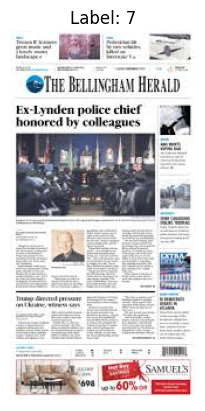

In [6]:
import matplotlib.pyplot as plt

image, label = train_ds[1]

# Display the image
plt.imshow(image)
plt.title(f'Label: {label}')
plt.axis('off')  # Hide the axis
plt.show()


**Labels to IDs**

In [7]:

label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name
print(label2id)
print(id2label)

{'battery': '0', 'biological': '1', 'brown-glass': '2', 'cardboard': '3', 'clothes': '4', 'green-glass': '5', 'metal': '6', 'paper': '7', 'plastic': '8', 'shoes': '9', 'trash': '10', 'white-glass': '11'}
{'0': 'battery', '1': 'biological', '2': 'brown-glass', '3': 'cardboard', '4': 'clothes', '5': 'green-glass', '6': 'metal', '7': 'paper', '8': 'plastic', '9': 'shoes', '10': 'trash', '11': 'white-glass'}


**Pre-Processing**

In [8]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [9]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [10]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


**Collator and Loader**

In [11]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=16, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, collate_fn=collator, num_workers=2)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Using Adam Optimizer**

In [12]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

**Set Training Parameters**

In [13]:

from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [14]:

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

**Training**

In [15]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
     

  0%|          | 0/7760 [00:00<?, ?it/s]

In [16]:
from datasets import load_metric

**Evaluation Metrics**

In [17]:

metric = load_metric("accuracy")
model.eval()
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9829197550757331}

In [18]:
'''from huggingface_hub import notebook_login

notebook_login()'''

'from huggingface_hub import notebook_login\n\nnotebook_login()'

In [19]:
#model.push_to_hub("watersplash/waste-classification")